# Importing necessay libraries

In [120]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Function for computational graph plotting

In [286]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | shape %s | grad %s}" % (n.label, str(n.tensor.shape), str(n.grad.shape)), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [287]:
df = pd.read_csv('cleaned_house_data')

In [322]:
df.head()

,bedrooms,bathrooms,stories,parking,furnishingstatus,log_price,log_area,area_bedrooms,area_bathrooms,bed_bath,amenities_count,total_rooms
0,4,2,3,2,2,16.403275,8.911934,35.647736,17.823868,8,3,6
1,4,4,4,3,2,16.321037,9.100526,36.402103,36.402103,16,2,8
2,3,2,2,2,1,16.321037,9.206332,27.618997,18.412664,6,3,5
3,4,2,2,3,2,16.318174,8.922658,35.690632,17.845316,8,4,6
4,4,1,2,2,2,16.250000,8.911934,35.647736,8.911934,4,4,5


In [323]:
df.columns

Index(['bedrooms', 'bathrooms', 'stories', 'parking', 'furnishingstatus',
       'log_price', 'log_area', 'area_bedrooms', 'area_bathrooms', 'bed_bath',
       'amenities_count', 'total_rooms'],
      dtype='object')

In [324]:
X = df.drop(columns = ['log_price'])
y = df['log_price']

In [325]:
X.shape, y.shape

((545, 11), (545,))

In [326]:
train_size = int(0.8 * len(X))
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [327]:
X_train = torch.tensor(X_train.to_numpy(), dtype = torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype = torch.float32)
y_train = y_train.view(-1, 1)

X_test = torch.tensor(X_test.to_numpy(), dtype = torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype = torch.float32)
y_test = y_test.view(-1, 1)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([436, 11]),
 torch.Size([436, 1]),
 torch.Size([109, 11]),
 torch.Size([109, 1]))

In [328]:
# for dim_x, dim_y in zip(shape_self, shape_other):
#     if dim_x != dim_y and dim_x != 1 and dim_y != 1:
#         raise ValueError("Tensors are not broadcastable")

# self_new_shape = [max(dim_x, dim_y) for dim_x, dim_y in zip(shape_self, shape_other)]
# other_new_shape = [max(dim_x, dim_y) for dim_x, dim_y in zip(shape_self, shape_other)]

# self.tensor = self.tensor.broadcast_to(tuple(reversed(self_new_shape)))
# other.tensor = other.tensor.broadcast_to(tuple(reversed(other_new_shape)))

# Manually created `TensorValue` class

In [329]:
y = torch.randn(2, 5, 7)
print(y.numel())

70


# With PyTorch's implicit broadcasting

In [330]:
class TensorValue:
    def __init__(self, tensor, label=None, grad=None, _prev=(), _op=None):
        """
            label
            tensor
            grad
            _prev
            _op
            _backward
            shape
            ndim
        """
        self.label = label
        self.tensor = tensor if isinstance(tensor, torch.Tensor) else torch.tensor(tensor, dtype=torch.float32)
        self.grad = torch.zeros_like(self.tensor) if grad is None else grad
        self._prev = set(_prev)
        self._op = _op
        self._backward = None
        self.shape = self.tensor.shape
        self.ndim = self.tensor.ndim

    def __repr__(self):
        return f"TensorValue(tensor={self.tensor}, grad={self.grad})"

    # To check shape mismatch and apply DEBROADCASTING
    def _match_shape(self, grad, target_shape):
        while len(grad.shape) > len(target_shape):
            grad = grad.sum(dim=0)
        for i, (g_dim, t_dim) in enumerate(zip(grad.shape, target_shape)):
            if g_dim != t_dim:
                grad = grad.sum(dim=i, keepdim=True)
        return grad

    #----------------------------------------------------
    # Add
    #----------------------------------------------------
    def __add__(self, other):
        output = TensorValue(self.tensor + other.tensor, _prev=(self, other), _op='+')

        def backward():
            self.grad += self._match_shape(output.grad, self.shape)
            other.grad += self._match_shape(output.grad, other.shape)

        output._backward = backward
        return output

   #----------------------------------------------------
   # Subtract
   #----------------------------------------------------
    def __sub__(self, other):
        output = TensorValue(self.tensor - other.tensor, _prev=(self, other), _op='-')

        def backward():
            self.grad += self._match_shape(output.grad, self.shape)
            other.grad += -self._match_shape(output.grad, other.shape)

        output._backward = backward
        return output

    #----------------------------------------------------
    # Multiply
    #----------------------------------------------------
    def __mul__(self, other):
        output = TensorValue(self.tensor * other.tensor, _prev=(self, other), _op='*')

        def backward():
            self.grad += self._match_shape(other.tensor * output.grad, self.shape)
            other.grad += self._match_shape(self.tensor * output.grad, other.shape)

        output._backward = backward
        return output

   #----------------------------------------------------
   # Right multiplication
   #----------------------------------------------------
    def __rmul__(self, other):
        if isinstance(other, (int, float)):
            output = TensorValue(self.tensor * other, _prev=(self,), _op='*')
            def backward():
                self.grad += other * output.grad
            output._backward = backward
            return output
        return self * other

   #----------------------------------------------------
   # Matrix Multiplication
   #----------------------------------------------------
    def __matmul__(self, other):
        output = TensorValue(self.tensor @ other.tensor, _prev=(self, other), _op='@')

        def backward():
            self.grad += output.grad @ other.tensor.T
            other.grad += self.tensor.T @ output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Power
    #----------------------------------------------------
    def __pow__(self, other):
        output = TensorValue(self.tensor ** other, _prev=(self,), _op='**')

        def backward():
            self.grad += (other * self.tensor ** (other - 1)) * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Mean
    #----------------------------------------------------
    def mean(self):
        output = TensorValue(self.tensor.mean(), _prev=(self,), _op='mean')

        def backward():
            self.grad += (torch.ones_like(self.tensor) / self.tensor.numel()) * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Topological Sort
    #----------------------------------------------------
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = torch.ones_like(self.tensor)
        for node in reversed(topo):
            node._backward()

# With Explicit Broadcasting

In [331]:
# (1,) * (len(shape2) - len(shape1)) + shape1
a = torch.randn((4,3))
print(a.shape)
(1,) * (3 - 2) + a.shape

torch.Size([4, 3])


(1, 4, 3)

If grad has more dimensions than self, it means some singleton dimensions (size 1) were missing during the forward pass.
So, sum over the extra dimensions one by one (starting from the leftmost dimensions) until the number of dimensions match.
dim=0 because the extra dimensions are usually leading dimensions (leftmost) when broadcasting.

In [332]:
def broadcast_shape(shape1, shape2):
  # Padding the shorter shape with 1s on the left
  if len(shape1) < len(shape2):
      shape1 = (1,) * (len(shape2) - len(shape1)) + shape1
  elif len(shape2) < len(shape1):
      shape2 = (1,) * (len(shape1) - len(shape2)) + shape2

  result = []

  for s1, s2 in zip(shape1, shape2):
    if s1 == 1:
        result.append(s2)
    elif s2 == 1:
        result.append(s1)
    elif s1 == s2:
        result.append(s1)
    else:
        raise ValueError("Shapes are not broadcastable")

  return tuple(result)

In [333]:
class TensorValue:
    """
            label
            tensor
            grad
            _prev
            _op
            _backward
            shape
            ndim
    """
    def __init__(self, tensor, label=None, grad=None, _prev=(), _op=None):
        self.label = label
        self.tensor = tensor if isinstance(tensor, torch.Tensor) else torch.tensor(tensor, dtype=torch.float32)
        self.grad = torch.zeros_like(self.tensor) if grad is None else grad
        self._prev = set(_prev)
        self._op = _op
        self._backward = lambda: None
        self.shape = self.tensor.shape
        self.ndim = self.tensor.ndim

    def __repr__(self):
        return f"TensorValue(tensor={self.tensor}, grad={self.grad})"

    def _broadcast_tensors(self, other):
        # Above function call
        out_shape = broadcast_shape(self.shape, other.shape)

        a_tensor = self.tensor.expand(out_shape)
        b_tensor = other.tensor.expand(out_shape)

        # Marking broadcasting operation as a node in computational graph
        a = TensorValue(a_tensor, _prev=(self,), _op='broadcast')
        a.label = self.label
        b = TensorValue(b_tensor, _prev=(other,), _op='broadcast')
        b.label = other.label

        def _backward_a():
            grad = a.grad
            while grad.ndim > len(self.shape):
                grad = grad.sum(dim=0)
            # Grad (1,2,3) and Tensor (1,1,4)
              # 1st iter => 1=1
              # 2nd iter => 2 != 1 => .sum happens at dim = 1 and so on.....
            for i, (g_dim, t_dim) in enumerate(zip(grad.shape, self.shape)):
                if t_dim == 1 and g_dim != 1:
                    grad = grad.sum(dim=i, keepdim=True)
            self.grad += grad

        def _backward_b():
            grad = b.grad
            while grad.ndim > len(other.shape):
                grad = grad.sum(dim=0)
            for i, (g_dim, t_dim) in enumerate(zip(grad.shape, other.shape)):
                if t_dim == 1 and g_dim != 1:
                    grad = grad.sum(dim=i, keepdim=True)
            other.grad += grad

        a._backward = _backward_a
        b._backward = _backward_b

        return a, b


    #----------------------------------------------------
    # Add
    #----------------------------------------------------
    def __add__(self, other):
        a, b = self._broadcast_tensors(other)
        output = TensorValue(a.tensor + b.tensor, _prev=(a, b), _op='+')

        def backward():
            a.grad += output.grad
            b.grad += output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Subtract
    #----------------------------------------------------
    def __sub__(self, other):
        a, b = self._broadcast_tensors(other)
        output = TensorValue(a.tensor - b.tensor, _prev=(a, b), _op='-')

        def backward():
            a.grad += output.grad
            b.grad += -output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Multiply
    #----------------------------------------------------
    def __mul__(self, other):
        a, b = self._broadcast_tensors(other)
        output = TensorValue(a.tensor * b.tensor, _prev=(a, b), _op='*')

        def backward():
            a.grad += b.tensor * output.grad
            b.grad += a.tensor * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Right multiplication
    #----------------------------------------------------
    def __rmul__(self, other):
        if isinstance(other, (int, float)):
            output = TensorValue(self.tensor * other, _prev=(self,), _op='*')
            def backward():
                self.grad += other * output.grad
            output._backward = backward
            return output
        return self * other

    #----------------------------------------------------
    # Matrix Multiplication
    #----------------------------------------------------
    def __matmul__(self, other):
        other = other if isinstance(other, TensorValue) else TensorValue(other)
        output = TensorValue(self.tensor @ other.tensor, _prev=(self, other), _op='@')

        def backward():
            self.grad += output.grad @ other.tensor.T
            other.grad += self.tensor.T @ output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Power
    #----------------------------------------------------
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int/float powers"
        output = TensorValue(self.tensor ** other, _prev=(self,), _op='**')

        def backward():
            self.grad += (other * self.tensor ** (other - 1)) * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Mean
    #----------------------------------------------------
    def mean(self):
        output = TensorValue(self.tensor.mean(), _prev=(self,), _op='mean')

        def backward():
            self.grad += (torch.ones_like(self.tensor) / self.tensor.numel()) * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Topological Sort
    #----------------------------------------------------
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = torch.ones_like(self.tensor)
        for node in reversed(topo):
            node._backward()


This is all implemented using the PyTorch's defaults, jsut done to verify if the auto differentiation of the TensorValue class works later below or not

In [334]:
W = torch.randn((11,1), dtype = torch.float32, requires_grad = True) * 0.01
b = torch.tensor([1.], requires_grad = True)

epochs = 1
lr = 0.001

for i in range(epochs):
  Z = X_train @ W + b
  print(Z.shape)

  L = (1/2) * ((Z - y_train) ** 2).mean()
  print(L.shape)
  print(L)
  W.retain_grad()
  b.retain_grad()
  L.backward()

print(W.grad)
print(b.grad)

torch.Size([436, 1])
torch.Size([])
tensor(101.7790, grad_fn=<MulBackward0>)
tensor([[ -43.6468],
        [ -19.2796],
        [ -27.1753],
        [ -11.3674],
        [ -15.0596],
        [-121.8095],
        [-373.0967],
        [-165.0795],
        [ -61.0370],
        [ -32.0596],
        [ -62.9264]])
tensor([-14.2643])


### Everything here is now converted into `TensorValue` class

In [335]:
X_train = TensorValue(X_train, label = 'x_train')
y_train = TensorValue(y_train, label = 'y_train')

W = torch.randn((11,1), dtype = torch.float32, requires_grad = True) * 0.01
b = torch.tensor([1.], requires_grad = True)
print(b)
print(b.shape)

W = TensorValue(W, label = 'w')
b = TensorValue(b, label = 'b')

tensor([1.], requires_grad=True)
torch.Size([1])


### Entire backpropagation done using the auto differentiation based `TensorValue` class

In [336]:
epochs = 1
lr = 0.001
print("y_train shape ::", y_train.shape)

for i in range(epochs):
  T = X_train @ W
  T.label = "T"
  Z = T + b
  Z.label = "Z"
  print(Z.shape)

  diff = Z - y_train
  diff.label = "diff"
  diff_2 = diff ** 2
  diff_2.label = "diff_2"
  diff_2_mean = diff_2.mean()
  diff_2_mean.label = "diff_2_mean"
  L1 = (1/2) * diff_2_mean
  L1.label = "Loss"

  print('------------------------------------------------')
  print("Z shape ::", Z.shape)
  print("Y_train shape ::", y_train.shape)
  print("Diff shape :: ",diff.shape)
  print("Mean shape :: ", diff_2_mean.shape)
  print("Loss value :: ",L)
  print('------------------------------------------------')

  diff_2_mean.tensor.retain_grad()
  diff_2.tensor.retain_grad()
  diff.tensor.retain_grad()
  Z.tensor.retain_grad()
  T.tensor.retain_grad()
  W.tensor.retain_grad()
  b.tensor.retain_grad()

  L1.backward()

print("The shape of loss's gradient")
print(L1.grad.shape)
print("---------------------------------------")
print("W's grad")
print(W.grad)
print("---------------------------------------")
print("b's grad")
print(b.grad)

y_train shape :: torch.Size([436, 1])
torch.Size([436, 1])
------------------------------------------------
Z shape :: torch.Size([436, 1])
Y_train shape :: torch.Size([436, 1])
Diff shape ::  torch.Size([436, 1])
Mean shape ::  torch.Size([])
Loss value ::  tensor(101.7790, grad_fn=<MulBackward0>)
------------------------------------------------
The shape of loss's gradient
torch.Size([])
---------------------------------------
W's grad
tensor([[ -44.7586],
        [ -19.7416],
        [ -27.8562],
        [ -11.6519],
        [ -15.4134],
        [-124.7164],
        [-382.6177],
        [-169.0456],
        [ -62.5972],
        [ -32.8447],
        [ -64.5003]], grad_fn=<AddBackward0>)
---------------------------------------
b's grad
tensor([-14.6040], grad_fn=<AddBackward0>)


## Plotting the computational graph

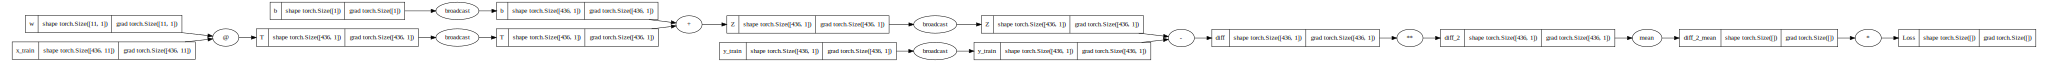

In [338]:
draw_dot(L1)
